In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/ailab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-01-13 00:07:24.503362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:07:24.508287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:07:24.508431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 00:07:24.509212: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

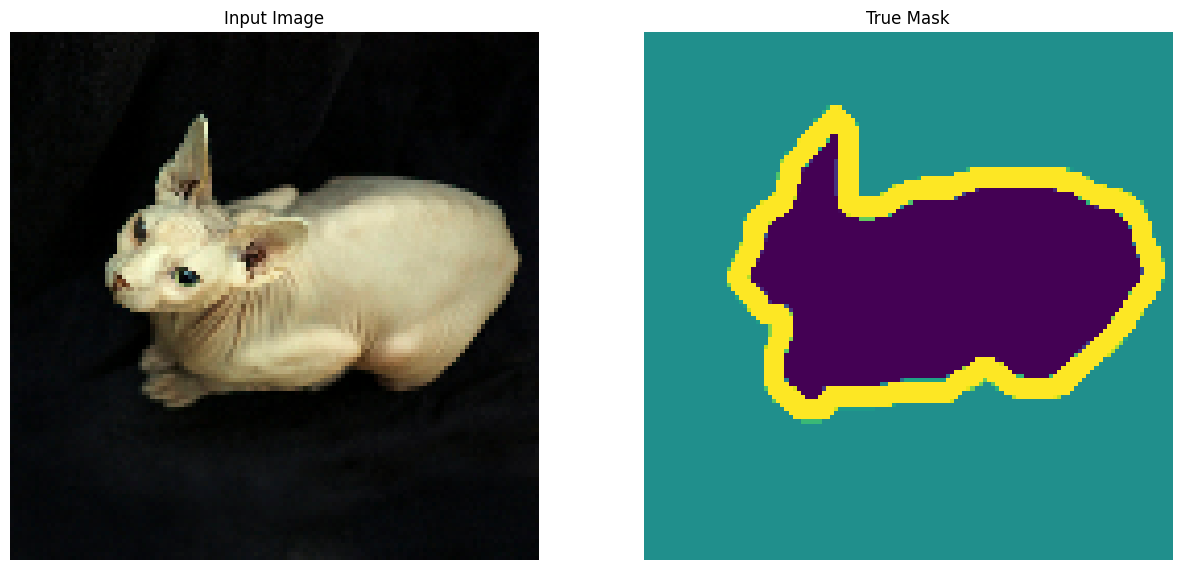

In [9]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [6]:
model = tf.keras.Sequential()    

# block 1
model.add(tf.keras.layers.Conv2D(64, 1, padding='same', activation='LeakyReLU', input_shape=(128, 128, 3)))
model.add(tf.keras.layers.BatchNormalization())

# block 2
model.add(tf.keras.layers.Conv2D(64, 1, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

# block 3
model.add(tf.keras.layers.Conv2D(64, 1, padding='same', activation='LeakyReLU'))
model.add(tf.keras.layers.BatchNormalization())

# output
model.add(tf.keras.layers.Conv2D(3, 1, padding='same'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      256       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 64)     2

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20
459/460 [============================>.] - ETA: 0s - loss: 0.8569 - accuracy: 0.5849

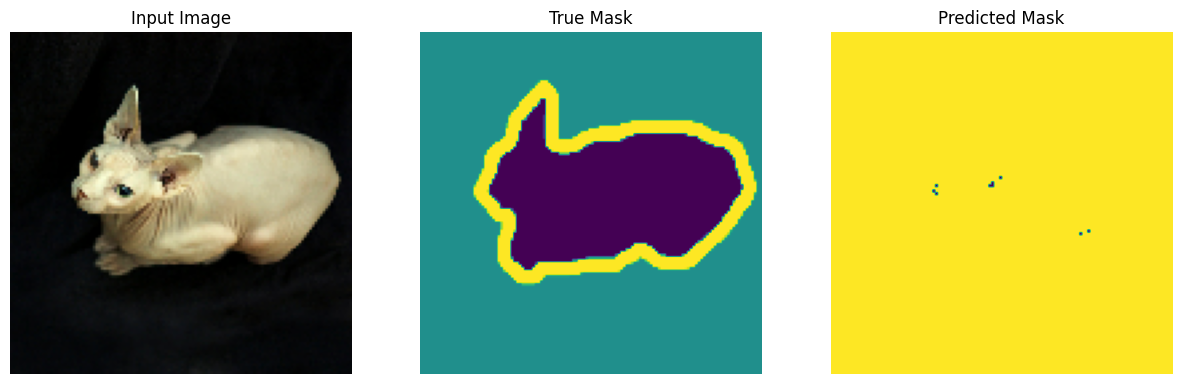


Sample Prediction after epoch 1

460/460 [==============================] - 5s 10ms/step - loss: 0.8570 - accuracy: 0.5848 - val_loss: 0.8903 - val_accuracy: 0.5501
Epoch 2/20
460/460 [==============================] - ETA: 0s - loss: 0.8524 - accuracy: 0.5828

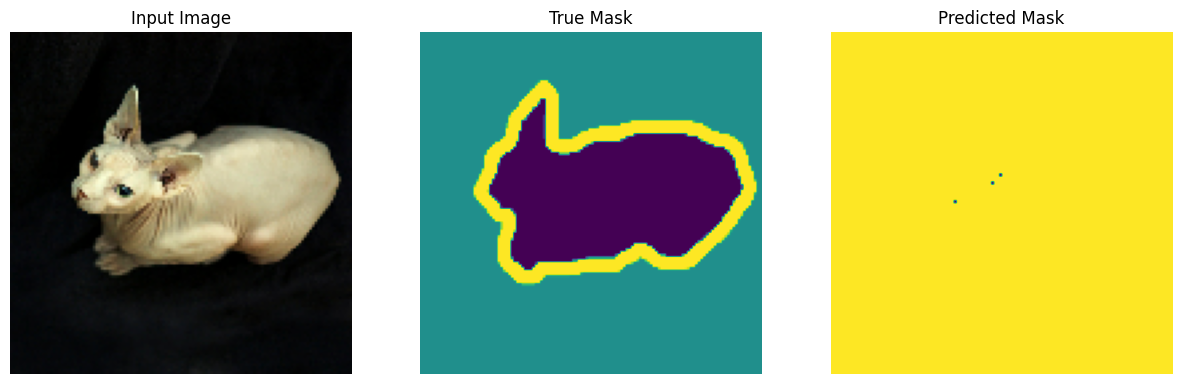


Sample Prediction after epoch 2

460/460 [==============================] - 5s 10ms/step - loss: 0.8524 - accuracy: 0.5828 - val_loss: 0.8652 - val_accuracy: 0.5716
Epoch 3/20
456/460 [============================>.] - ETA: 0s - loss: 0.8541 - accuracy: 0.5836

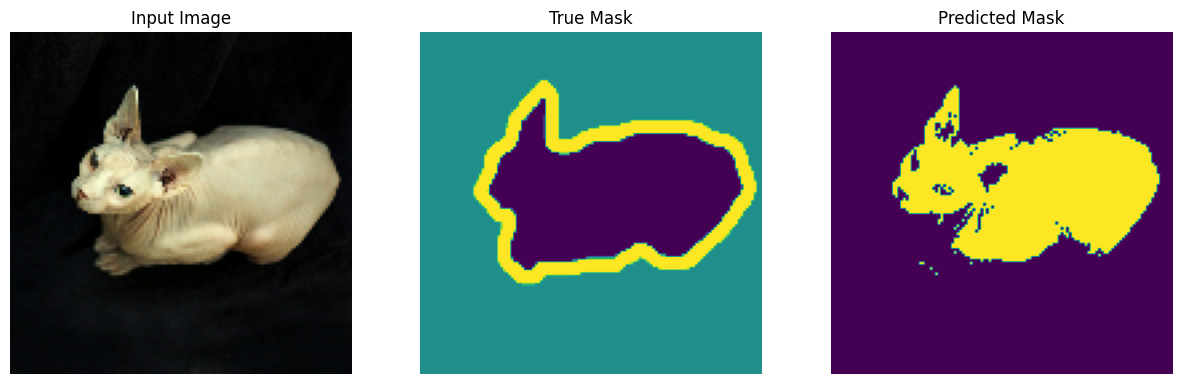


Sample Prediction after epoch 3

460/460 [==============================] - 5s 10ms/step - loss: 0.8538 - accuracy: 0.5839 - val_loss: 0.9244 - val_accuracy: 0.5240
Epoch 4/20
457/460 [============================>.] - ETA: 0s - loss: 0.8529 - accuracy: 0.5851

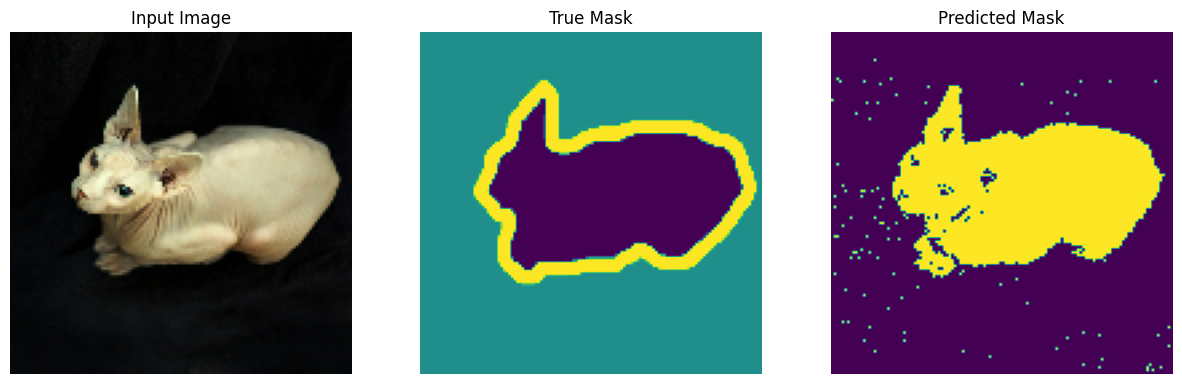


Sample Prediction after epoch 4

460/460 [==============================] - 5s 10ms/step - loss: 0.8527 - accuracy: 0.5851 - val_loss: 0.8988 - val_accuracy: 0.5461
Epoch 5/20
459/460 [============================>.] - ETA: 0s - loss: 0.8532 - accuracy: 0.5836

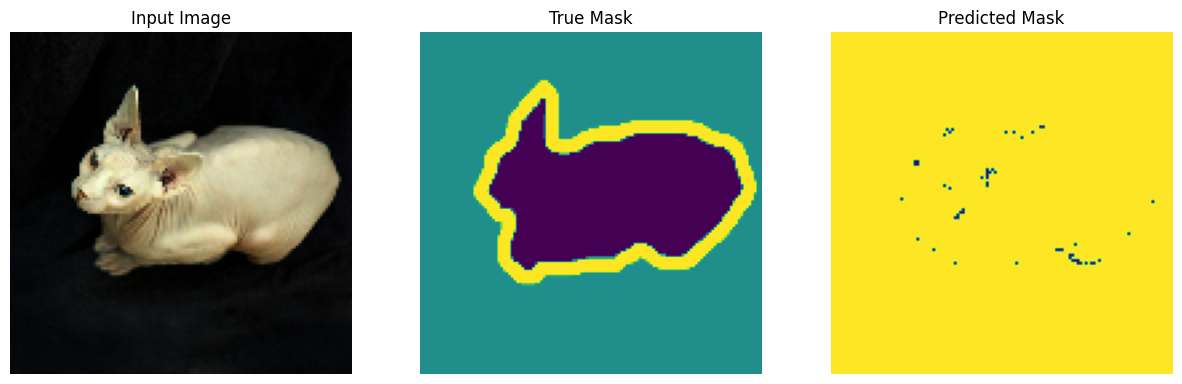


Sample Prediction after epoch 5

460/460 [==============================] - 5s 10ms/step - loss: 0.8533 - accuracy: 0.5835 - val_loss: 0.8605 - val_accuracy: 0.5733
Epoch 6/20
457/460 [============================>.] - ETA: 0s - loss: 0.8519 - accuracy: 0.5842

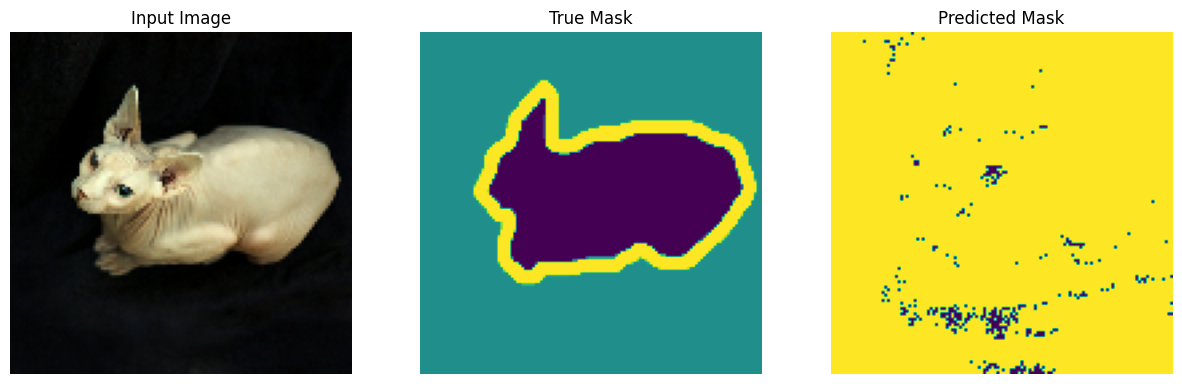


Sample Prediction after epoch 6

460/460 [==============================] - 5s 10ms/step - loss: 0.8518 - accuracy: 0.5841 - val_loss: 0.8638 - val_accuracy: 0.5814
Epoch 7/20
457/460 [============================>.] - ETA: 0s - loss: 0.8523 - accuracy: 0.5852

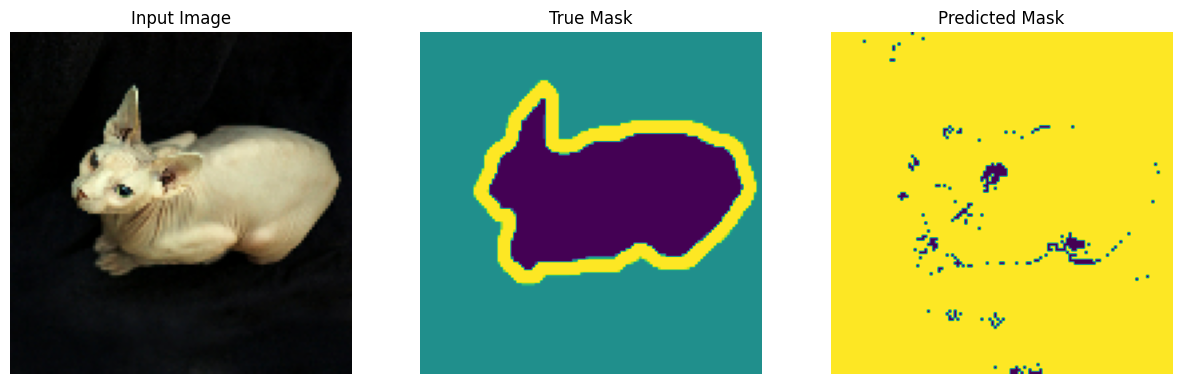


Sample Prediction after epoch 7

460/460 [==============================] - 5s 10ms/step - loss: 0.8521 - accuracy: 0.5855 - val_loss: 0.8625 - val_accuracy: 0.5761
Epoch 8/20
458/460 [============================>.] - ETA: 0s - loss: 0.8501 - accuracy: 0.5864

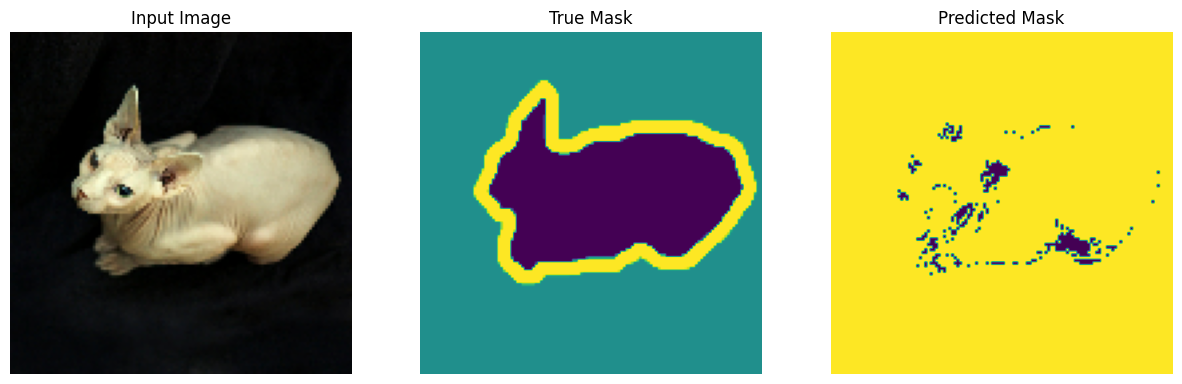


Sample Prediction after epoch 8

460/460 [==============================] - 5s 10ms/step - loss: 0.8501 - accuracy: 0.5863 - val_loss: 0.8611 - val_accuracy: 0.5758
Epoch 9/20
460/460 [==============================] - ETA: 0s - loss: 0.8472 - accuracy: 0.5898

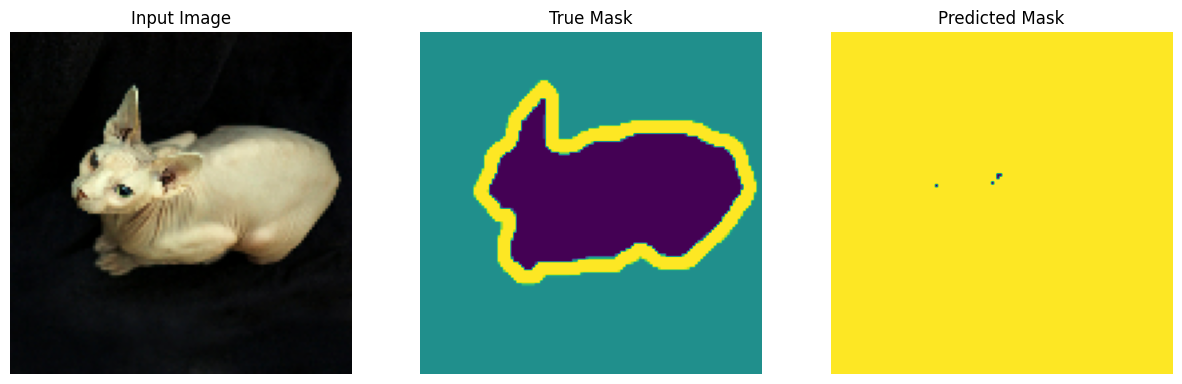


Sample Prediction after epoch 9

460/460 [==============================] - 5s 10ms/step - loss: 0.8472 - accuracy: 0.5898 - val_loss: 0.8657 - val_accuracy: 0.5726
Epoch 10/20
460/460 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.5847

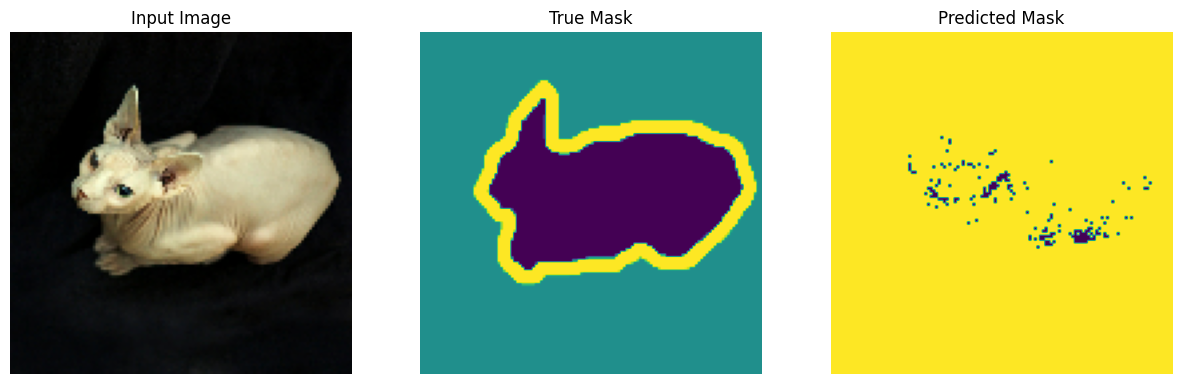


Sample Prediction after epoch 10

460/460 [==============================] - 5s 10ms/step - loss: 0.8511 - accuracy: 0.5847 - val_loss: 0.9050 - val_accuracy: 0.5307
Epoch 11/20
458/460 [============================>.] - ETA: 0s - loss: 0.8485 - accuracy: 0.5871

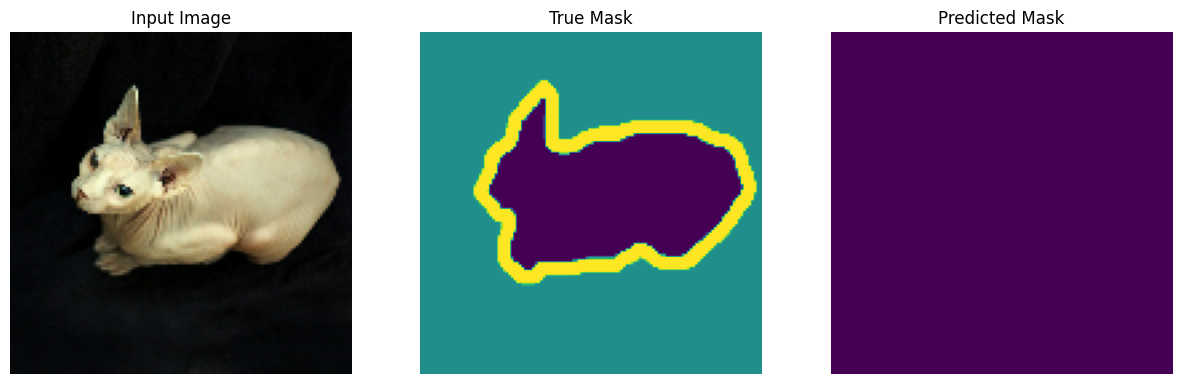


Sample Prediction after epoch 11

460/460 [==============================] - 5s 10ms/step - loss: 0.8488 - accuracy: 0.5870 - val_loss: 0.9095 - val_accuracy: 0.5678
Epoch 12/20
457/460 [============================>.] - ETA: 0s - loss: 0.8507 - accuracy: 0.5857

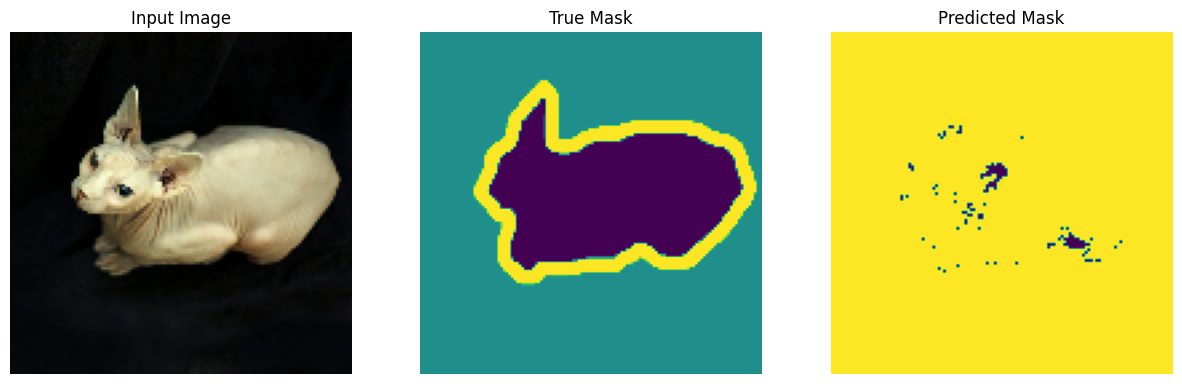


Sample Prediction after epoch 12

460/460 [==============================] - 5s 10ms/step - loss: 0.8508 - accuracy: 0.5854 - val_loss: 0.8617 - val_accuracy: 0.5755
Epoch 13/20
457/460 [============================>.] - ETA: 0s - loss: 0.8500 - accuracy: 0.5857

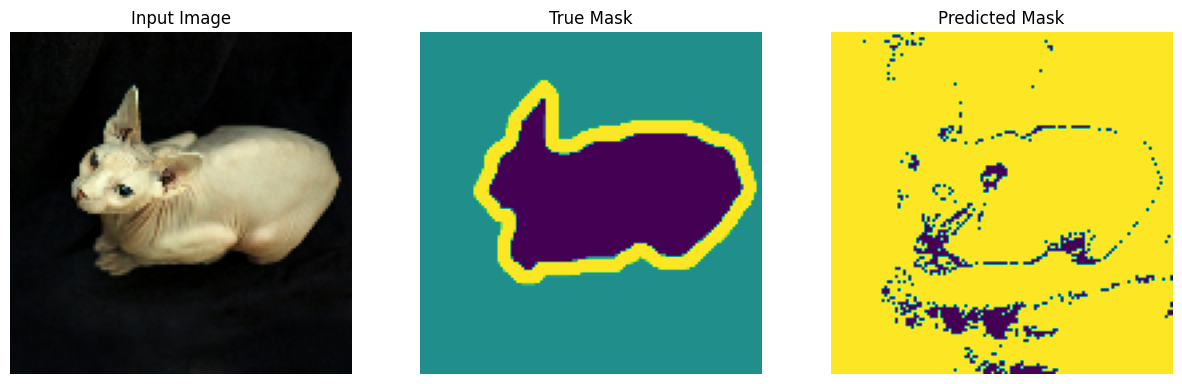


Sample Prediction after epoch 13

460/460 [==============================] - 5s 10ms/step - loss: 0.8497 - accuracy: 0.5860 - val_loss: 0.8782 - val_accuracy: 0.5590
Epoch 14/20
457/460 [============================>.] - ETA: 0s - loss: 0.8486 - accuracy: 0.5872

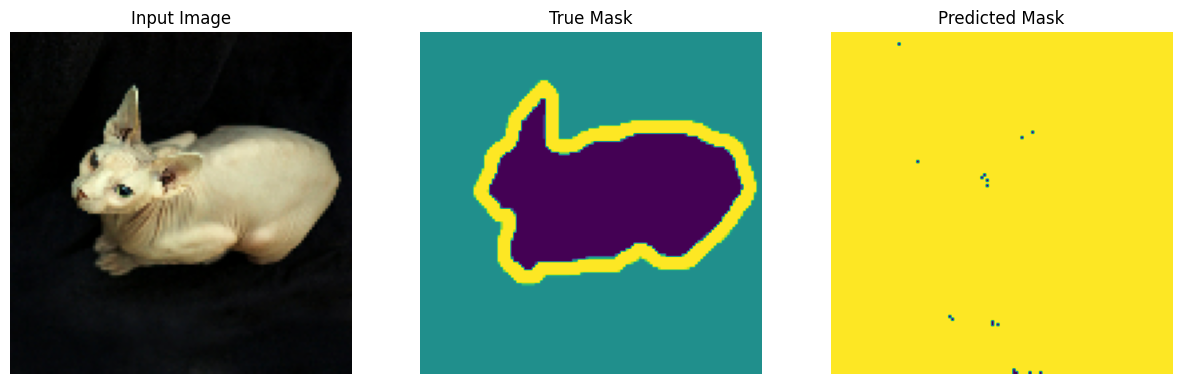


Sample Prediction after epoch 14

460/460 [==============================] - 5s 10ms/step - loss: 0.8486 - accuracy: 0.5873 - val_loss: 0.8631 - val_accuracy: 0.5753
Epoch 15/20
457/460 [============================>.] - ETA: 0s - loss: 0.8489 - accuracy: 0.5879

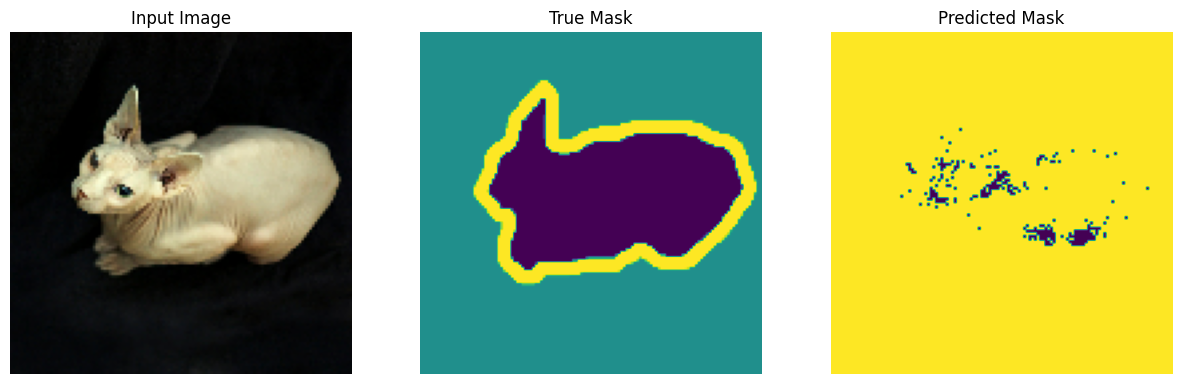


Sample Prediction after epoch 15

460/460 [==============================] - 5s 10ms/step - loss: 0.8491 - accuracy: 0.5876 - val_loss: 0.8783 - val_accuracy: 0.5434
Epoch 16/20
457/460 [============================>.] - ETA: 0s - loss: 0.8479 - accuracy: 0.5870

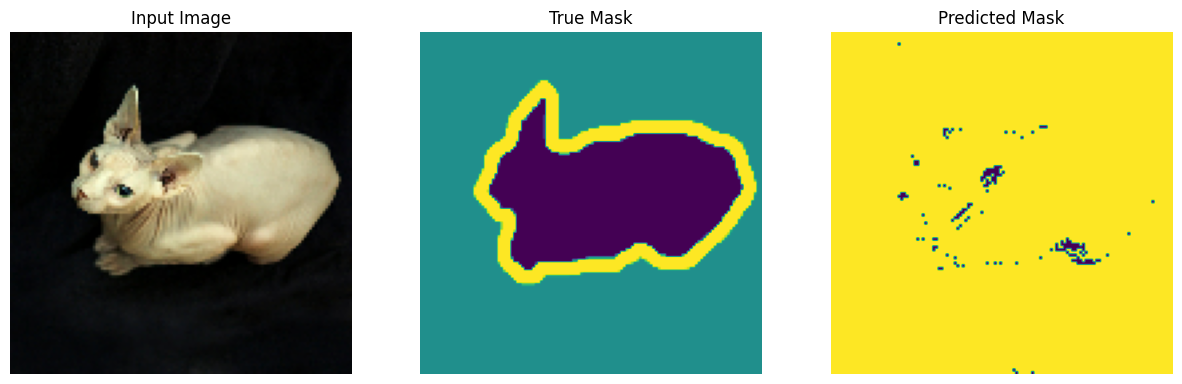


Sample Prediction after epoch 16

460/460 [==============================] - 5s 10ms/step - loss: 0.8477 - accuracy: 0.5873 - val_loss: 0.8616 - val_accuracy: 0.5749
Epoch 17/20
457/460 [============================>.] - ETA: 0s - loss: 0.8485 - accuracy: 0.5865

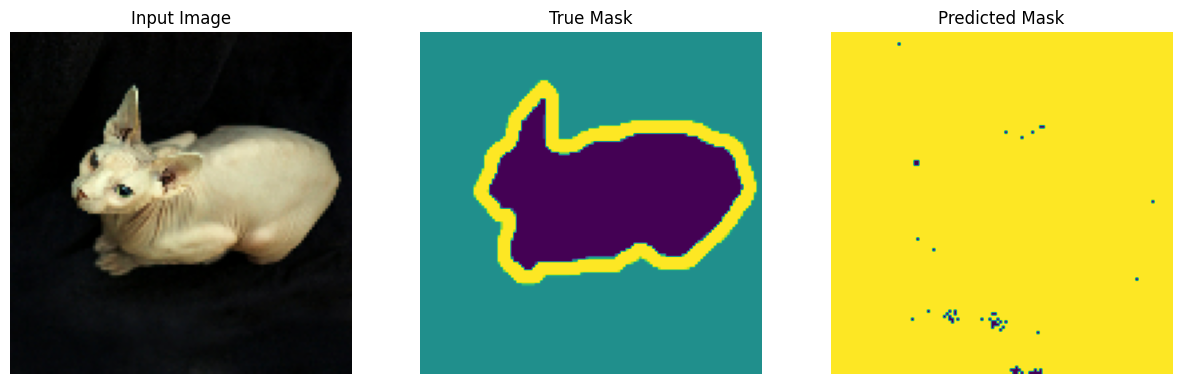


Sample Prediction after epoch 17

460/460 [==============================] - 5s 10ms/step - loss: 0.8488 - accuracy: 0.5865 - val_loss: 0.8608 - val_accuracy: 0.5761
Epoch 18/20
455/460 [============================>.] - ETA: 0s - loss: 0.8477 - accuracy: 0.5893

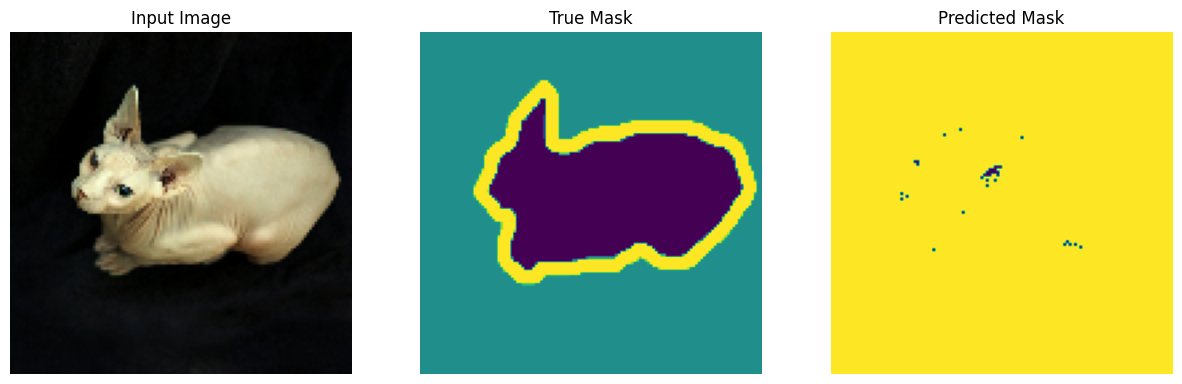


Sample Prediction after epoch 18

460/460 [==============================] - 5s 10ms/step - loss: 0.8481 - accuracy: 0.5889 - val_loss: 0.8580 - val_accuracy: 0.5744
Epoch 19/20
459/460 [============================>.] - ETA: 0s - loss: 0.8482 - accuracy: 0.5872

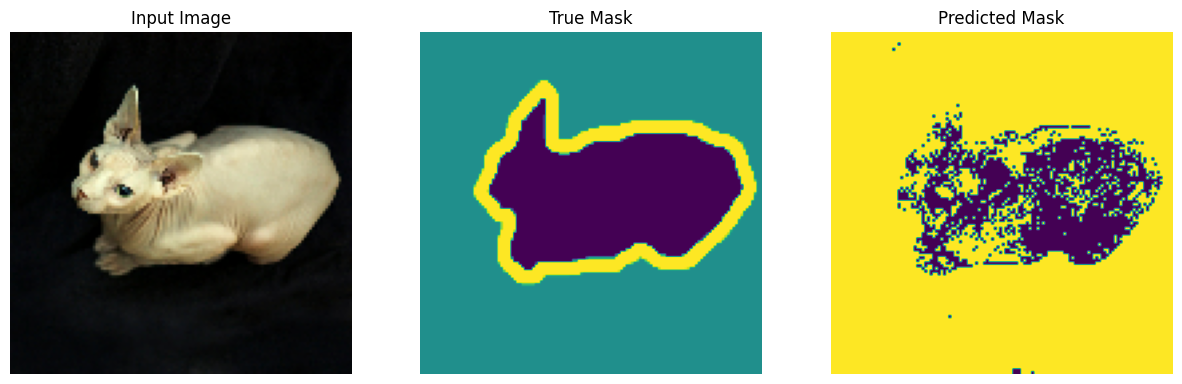


Sample Prediction after epoch 19

460/460 [==============================] - 5s 11ms/step - loss: 0.8480 - accuracy: 0.5874 - val_loss: 0.8898 - val_accuracy: 0.5298
Epoch 20/20
455/460 [============================>.] - ETA: 0s - loss: 0.8466 - accuracy: 0.5904

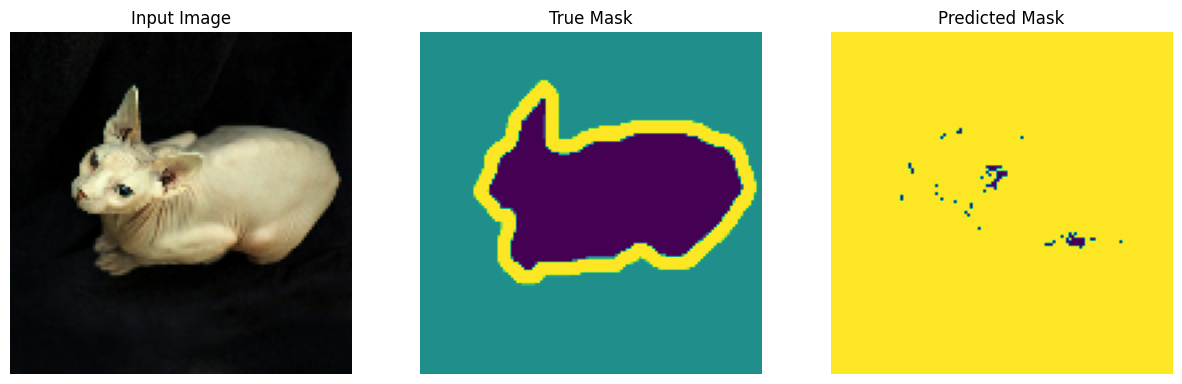


Sample Prediction after epoch 20

460/460 [==============================] - 5s 10ms/step - loss: 0.8471 - accuracy: 0.5898 - val_loss: 0.8612 - val_accuracy: 0.5744


In [10]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

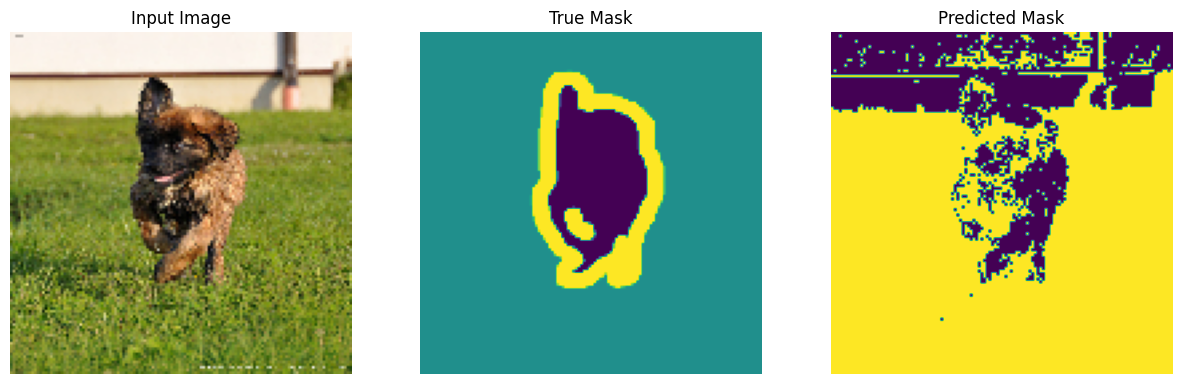

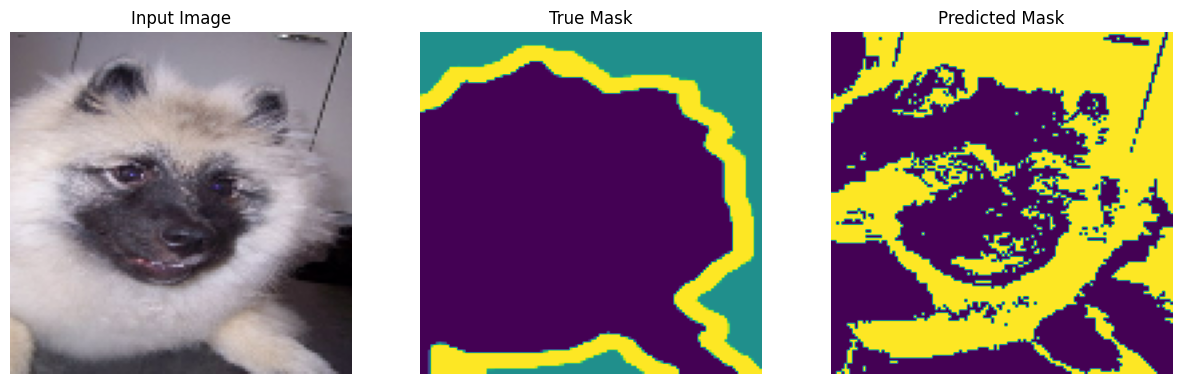

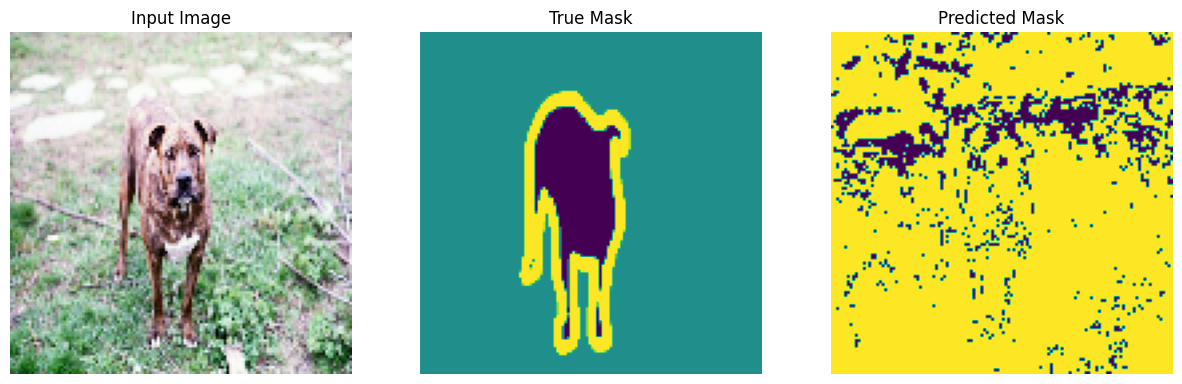

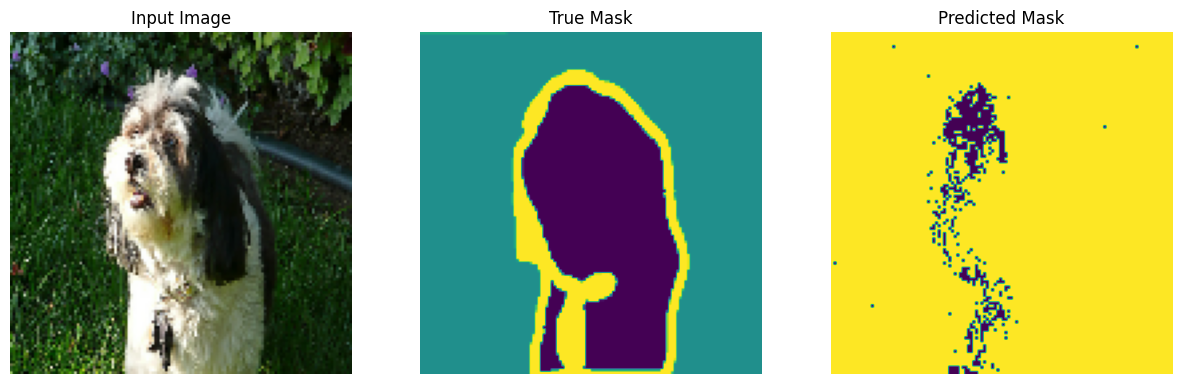

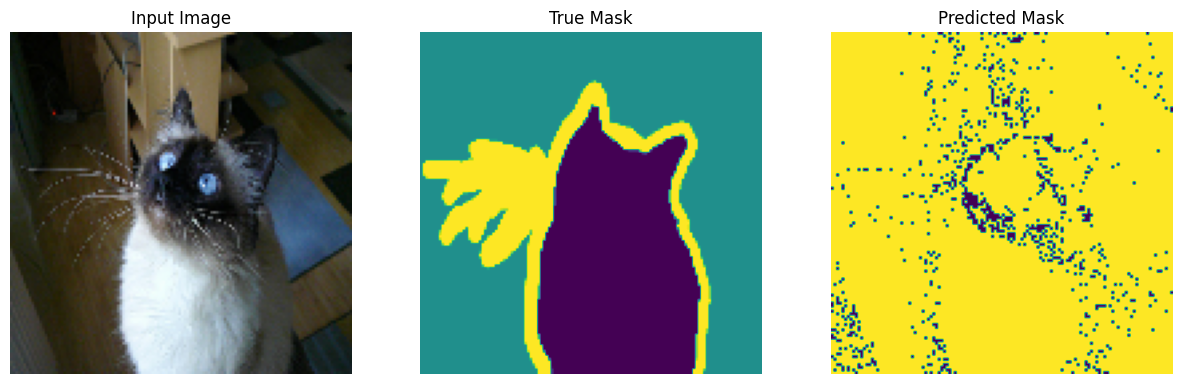

In [11]:
show_predictions(test_dataset, 5)